In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import tqdm 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from matplotlib import animation, rc
rc('animation', html='html5')

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.nn.utils.rnn import pack_sequence, pad_sequence, pack_padded_sequence, pad_packed_sequence

from src.data.SkeletonFrame import SkeletonFrame
from src.data.ShapeManager import Data
from src.data.NSMDataset import NSMRawDataset


In [6]:
def play_clip(path):
    if os.name == 'nt':
        os.system('C:/Users/haikm/Envs/ai7/Scripts/python.exe ./run_model.py %s' % path)
    else:
        os.system('./run_model.py %s' % path)        
        
def play(clip):
    clip = clip.copy()
    clip.unnormalize()
    np.save('./data/tmp/clip.npy', clip.data)
    play_clip('./data/tmp/clip.npy')

In [4]:
dataset_raw = NSMRawDataset(to_torch=True)

train_set = Data(dataset_raw.train_data, np.load('./data/input_norm.npy'), "input", "./data/TrainSequencesClipped.txt")
test_set = Data(dataset_raw.test_data, np.load('./data/input_norm.npy'), "input", "./data/TestSequencesClipped.txt")

train_set.normalize()
test_set.normalize()

train_set.data = train_set.data.float()
test_set.data = test_set.data.float()

In [24]:
# # Only one type of motion!

train_walk = (train_set.trajectory_action_labels == 'Walk').all(1)
test_walk = (test_set.trajectory_action_labels == 'Walk').all(1)

train_set.data = train_set.data[train_walk]
test_set.data = test_set.data[test_walk]

In [8]:
class GRUNet(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims, n_layers):
        super(GRUNet, self).__init__()
        self.input_dims = input_dims
        self.hidden_dims = hidden_dims
        self.output_dims = output_dims
        self.n_layers = n_layers
        
        self.gru = nn.GRU(input_dims, hidden_dims, n_layers)
        self.fc = nn.Linear(hidden_dims,output_dims)
        
    def forward(self, input, h = None):
        input_batch = []
        for clip in input:
            frame = torch.cat([clip.bones, clip.goal_action[:,0], clip.trajectory_action[:,0]], 1)
            input_batch.append(frame.cuda())
            
        input_packed = pack_sequence(input_batch, enforce_sorted = False).float()
        
        out_packed, h = self.gru(input_packed, h)
        out_padded, lengths = pad_packed_sequence(out_packed)
        out_padded = self.fc(out_padded)
        out = [x[:l] for x,l in zip(out_padded.transpose(1,0), lengths)]

        return out, h
    
    def initHidden(self, batch_size):
        return torch.zeros((self.n_layers, batch_size, self.hidden_dims))

In [9]:
def evaluate(model, test_set):
    model.eval()
    i = 0
    input_batch = []
    output_batch = []
    while i < len(test_set.clips):
        input_batch.append(test_set(i)[:-1])
        output_batch.append(test_set(i)[1:].bones.cuda())
        i += 1

        if len(input_batch) == batch_size:
            output_batch_, h = model(input_batch)

            loss = 0
            for output, output_ in zip(output_batch, output_batch_):
                loss += criterion(output, output_)
            loss /= len(output_batch)

            input_batch = []
            output_batch = []
    return loss

In [26]:
model = GRUNet(289,256,276,2).cuda()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

In [27]:
batch_size = 64
n_epochs = 2
display_step = 100


for epoch in range(n_epochs):
    model.train()
    order = torch.randperm(len(train_set.clips))
    pbar = tqdm.tqdm(range(len(train_set.clips))[::batch_size])
    
    for idx in pbar:
        batch_order = order[:batch_size]
        order = order[batch_size:]

        input_batch = [train_set(x)[:-1] for x in batch_order]
        output_batch = [train_set(x)[1:].bones.cuda() for x in batch_order]

        optimizer.zero_grad()

        output_batch_, h = model(input_batch)
        
        loss = 0
        for output, output_ in zip(output_batch, output_batch_):
            loss += criterion(output, output_)
        loss /= len(output_batch)

        loss.backward()
        optimizer.step()

        pbar.set_description("Epoch [%d] of [%d]: Train Loss: %f" % (epoch + 1, n_epochs, loss.item()))
        
    loss = evaluate(model, test_set)
    print("Validation Loss: %f" % (loss.item()))

  0%|                                                                                           | 0/15 [00:00<?, ?it/s]


IndexError: index 142316 is out of bounds for dimension 0 with size 61460

In [12]:
# model = torch.load('./models/GRU/walk_2.pt')

In [13]:
# TEsting with self output to input
# 
# clip = test_set(np.random.randint(len(test_set.clips)))
# clip = test_set(0)
clip = train_set(0)

dims = clip[0].data.shape[-1]
dims = 276

hidden = None
initial = 1
out = Data(np.zeros((500,dims)), np.load('./data/input_norm.npy'), "input")

current = clip[:1]
action_idx = 5
control_traj = torch.from_numpy(np.eye(7, dtype = np.float32)[action_idx:action_idx+1].repeat(13, axis = 0))
control_goal = torch.from_numpy(np.eye(6, dtype = np.float32)[action_idx:action_idx+1].repeat(13, axis = 0))

current.trajectory_action = control_traj
current.goal_action = control_goal

for step in range(initial):
    current_out, hidden = model([clip[step:step+1]], hidden)    
    current.data[:,:dims] = current_out[0]
    out.data[step] = current_out[0].cpu().detach().numpy()
    
for step in range(initial, 500):
    current_out, hidden = model([current], hidden)
    current.data[:,:dims] = current_out[0]
    
    out.data[step] = current_out[0].cpu().detach().numpy()

out.unnormalize()
np.save('./data/rnn/test_output.npy', out.data)

clip.data = clip.data.detach().cpu().numpy()
clip.unnormalize()
np.save('./data/rnn/test_clip.npy', clip.data)
play_clip('./data/rnn/test_output.npy')

In [ ]:
play_clip('./data/rnn/test_clip.npy')

In [ ]:
play_clip('./data/rnn/test_output.npy')

c:\users\haikm\envs\ai7\lib\site-packages\matplotlib\collections.py:922: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


c:\users\haikm\envs\ai7\lib\site-packages\matplotlib\collections.py:922: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
c:\users\haikm\envs\ai7\lib\site-packages\mpl_toolkits\mplot3d\proj3d.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([xs, ys, zs, np.ones_like(xs)])


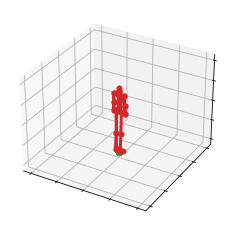

In [23]:
sample = train_set[0].copy()
sample.unnormalize()
frame = SkeletonFrame(sample)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
frame.draw(ax)

In [10]:
play(train_set(0))

In [ ]:
train_set

In [15]:
(train_set(0).trajectory_action_labels == 'Walk').any(1)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,